In [15]:
#load packages

import numpy as np
import matplotlib.pyplot as pl
import h5py
import batman
import emcee
import george
import corner
import os
import glob
import sys
import io
import warnings
import logging
import ultranest
import pandas as pd
import pickle

from scipy import special
from scipy.stats import binned_statistic

In [31]:
# Set global font properties for all matplotlib plots
import matplotlib.pyplot as pl

# Configure global font settings
pl.rcParams['font.size'] = 15
pl.rcParams['axes.titlesize'] = 17
pl.rcParams['axes.labelsize'] = 15
pl.rcParams['xtick.labelsize'] = 14
pl.rcParams['ytick.labelsize'] = 14
pl.rcParams['legend.fontsize'] = 13
pl.rcParams['figure.titlesize'] = 19

# Optional: Change font family (uncomment if you want to change the font type)
# pl.rcParams['font.family'] = 'serif'  # Options: 'serif', 'sans-serif', 'monospace'
# pl.rcParams['font.serif'] = ['Times New Roman']  # Specific serif font
# pl.rcParams['font.sans-serif'] = ['Arial']  # Specific sans-serif font

print("Global font settings updated for all plots")

Global font settings updated for all plots


In [17]:
# Define the root directory containing all planet light curve folders
root_dir = "trappist_all_prepared_light_curve_files/"

# Only load TRAPPIST-1e_2023-06-22
selected_keys = ["TRAPPIST-1e-1b_2025-10-29"]

file_list = []
for key in selected_keys:
    planet, date = key.split("_", 1)
    files = sorted(glob.glob(os.path.join(root_dir, planet, date, "prepared_light_curve.h5")))
    file_list.extend(files)

print(f"Found {len(file_list)} light curve files for selected keys: {selected_keys}")

# Load all data into a dictionary, removing NaNs from wavelength and corresponding fluxes
data_dict_flares_new = {}
for fn in file_list:
    planet = os.path.basename(os.path.dirname(os.path.dirname(fn)))
    date = os.path.basename(os.path.dirname(fn))
    key = f"{planet}_{date}"
    with h5py.File(fn, 'r') as f:
        mask = ~np.isnan(f['wavelength'][:])
        data_dict_flares_new[key] = {
            'bjd': f['bjd'][:],
            'bjd_binned': f['bjd_binned'][:],
            'flux': f['flux'][:, mask],
            'flux_binned': f['flux_binned'][:, mask],
            'flux_err': f['flux_err'][:, mask],
            'flux_err_binned': f['flux_err_binned'][:, mask],
            'it_index': f['it_index'][:],
            'it_index_non_binned': f['it_index_non_binned'][:],
            'oot_index': f['oot_index'][:],
            'oot_index_non_binned': f['oot_index_non_binned'][:],
            'wavelength': f['wavelength'][mask],
            'white_binned': f['white_binned'][:],
            'white_err_binned': f['white_err_binned'][:]
        }

Found 1 light curve files for selected keys: ['TRAPPIST-1e-1b_2025-10-29']


In [18]:
#Define FLARE MODEL

from scipy import special
from scipy.stats import binned_statistic

def flare_eqn(t,tpeak,fwhm,ampl):
    '''
    The equation that defines the shape for the Continuous Flare Model
    '''
    #Values were fit & calculated using MCMC 256 walkers and 30000 steps 
    #From Tovar Mendoza et al. (2022) DOI 10.3847/1538-3881/ac6fe6 (Llamaradas Estelares: Modeling the Morphology of White-Light Flares)

    A,B,C,D1,D2,f1 = [0.9687734504375167,-0.251299705922117,0.22675974948468916,
                      0.15551880775110513,1.2150539528490194,0.12695865022878844]

    # We include the corresponding errors for each parameter from the MCMC analysis

    A_err,B_err,C_err,D1_err,D2_err,f1_err = [0.007941622683556804,0.0004073709715788909,0.0006863488251125649,
                                              0.0013498012884345656,0.00453458098656645,0.001053149344530907 ]

    f2 = 1-f1

    eqn = ((1 / 2) * np.sqrt(np.pi) * A * C * f1 * np.exp(-D1 * t + ((B / C) + (D1 * C / 2)) ** 2)
                        * special.erfc(((B - t) / C) + (C * D1 / 2))) + ((1 / 2) * np.sqrt(np.pi) * A * C * f2
                        * np.exp(-D2 * t+ ((B / C) + (D2 * C / 2)) ** 2) * special.erfc(((B - t) / C) + (C * D2 / 2)))
    return eqn * ampl


def flare_model(t,tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Continuous Flare Model evaluated for single-peak (classical) flare events.
    Use this function for fitting classical flares with most curve_fit
    tools. Reference: Tovar Mendoza et al. (2022) DOI 10.3847/1538-3881/ac6fe6

    References
    --------------
    Tovar Mendoza et al. (2022) DOI 10.3847/1538-3881/ac6fe6
    Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Jackman et al. (2018) https://arxiv.org/abs/1804.03377

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over

    tpeak : float
        The center time of the flare peak

    fwhm : float
        The Full Width at Half Maximum, timescale of the flare

    ampl : float
        The amplitude of the flare


    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time

        A continuous flare template whose shape is defined by the convolution of a Gaussian and double exponential
        and can be parameterized by three parameters: center time (tpeak), FWHM, and ampitude
    '''

    t_new = (t-tpeak)/fwhm

    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new) - dt, max(t_new) + dt, t_new.size * uptime)

        flareup = flare_eqn(timeup,tpeak,fwhm,ampl)

        # and now downsample back to the original time...

        downbins = np.concatenate((t_new - dt / 2.,[max(t_new) + dt / 2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=np.sort(downbins))
    else:

        flare = flare_eqn(t_new,tpeak,fwhm,ampl)

    return flare

In [19]:
# UNCOMMENT BELOW FOR SPAWNING JOBS IN THE CLUSTER
import argparse

# -----------------------------
# Parse offset argument
# -----------------------------
parser = argparse.ArgumentParser()
parser.add_argument("--offset", type=float, required=True, help="Offset value for injected transit")
args = parser.parse_args()

offset_list = [args.offset]
print(f"Running MCMC for offset = {args.offset:.5f}")


# UNCOMMENT BELOW FOR TESTING LOCALLY

#offset_list = [0.02]  # Manually set offsets for testing

usage: ipykernel_launcher.py [-h] --offset OFFSET
ipykernel_launcher.py: error: the following arguments are required: --offset


SystemExit: 2

In [22]:
import george
from george import kernels

import multiprocessing as mp

def safe_flare_model(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    # wrap the original flare_model to convert non-finite -> large-suppressed values
    try:
        f = flare_model(t, tpeak, fwhm, ampl, upsample=upsample, uptime=uptime)
    except Exception:
        # if flare_model raises, return NaNs so lnlike will reject
        return np.full_like(t, np.nan)
    # replace any non-finite values with NaN (lnlike will handle)
    if not np.all(np.isfinite(f)):
        f = np.where(np.isfinite(f), f, np.nan)
    return f

# Fit a batman model with a linear systematics model plus a flare model plus a GP

# -----------------------------
# Priors
# -----------------------------
# Set up priors and likelihood function for MCMC

# From visually inpecting the light curve:
tpeak_min = 2460978.670
tpeak_max = 2460978.675
fwhm_max = 0.005
ampl_max = 0.3

def lnprior(theta):
    rp, slope, intercept, tpeak, fwhm, ampl, sigma, l = theta
    #if (0.0 < rp < 0.2 and -0.03 < slope < 0.03 and -0.003 < intercept < 0.003 and
    #    tpeak_min < tpeak < tpeak_max and 0.0001 < fwhm < 0.01 and 0.00001 < ampl < 0.3 and
    #    0.0001 < sigma < 0.3 and 0.00001 < l < 0.01):  # reasonable ranges
    if (0.0 < rp < 0.2 and -0.03 < slope < 0.03 and -0.003 < intercept < 0.003 and
        tpeak_min < tpeak < tpeak_max and 0.0001 < fwhm < fwhm_max and 0.00001 < ampl < ampl_max and
        0.00001 < sigma < 0.5 and 0.000001 < l < 0.01):
        return 0.0
    return -np.inf


def build_gp(sigma, l, time, flux_err):
    kernel = sigma**2 * kernels.Matern52Kernel(l)
    gp = george.GP(kernel)#, mean=mean_model)
    gp.compute(time, flux_err)   # factorize covariance matrix
    return gp


# -----------------------------
# Likelihood
# -----------------------------
def lnlike(theta, time, flux, flux_err):
    rp, slope, intercept, tpeak, fwhm, ampl, sigma, l = theta

    # quick guard: ensure numeric finite params (protect from inf/nan in proposals)
    if not np.all(np.isfinite(theta)):
        return -np.inf
    
    # Transit model
    params.rp = rp
    model = batman.TransitModel(params, time)
    try:
        model_flux = model.light_curve(params)
    except Exception:
        return -np.inf
    
    # Linear systematics
    systematic = slope * (time - time[0]) + intercept
    model_with_systematics = model_flux + systematic
    
    # Flare model — use safe wrapper
    flare = safe_flare_model(time, tpeak, fwhm, ampl)
    # if flare has non-finite values -> reject
    if not np.all(np.isfinite(flare)):
        return -np.inf
    model_with_systematics += flare

    # Compute log likelihood (MCMC log likelihood (measure of the goodness of the model fit to the data))
    
    # Previously:
    # This is the log-likelihood for Gaussian errors:
    # lnL = -0.5 * sum(((data - model)/error)^2)
    # It assumes each data point is independent and normally distributed around the model value.
    #return -0.5 * np.sum(((flux - model_with_systematics ) / flux_err) ** 2) 

    # Now with GP:
    # In george, if you set a mean function (mean=model_with_systematics), you should pass the raw flux into gp.log_likelihood.
    # If you don’t use a mean, you’d instead pass the residuals (flux - model).
    # You can test both approaches depending on whether you want the GP to add on top of the physical model, or to model only the correlated noise.

    # residuals
    residuals = flux - model_with_systematics

    # guard: flux and flux_err must be finite
    if not (np.all(np.isfinite(flux)) and np.all(np.isfinite(flux_err)) and np.all(np.isfinite(residuals))):
        return -np.inf

    # Build GP and evaluate log-likelihood safely (catch exceptions)
    try:
        gp = build_gp(sigma, l, time, flux_err)
    except Exception:
        return -np.inf

    try:
        ll = gp.log_likelihood(residuals)
    except Exception:
        # george may throw ValueError when Cholesky fails due to numerical issues
        return -np.inf

    # If ll is not finite reject
    if not np.isfinite(ll):
        return -np.inf

    return ll

# -----------------------------
# Posterior
# -----------------------------
def lnprob(theta, time, flux, flux_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = lnlike(theta, time, flux, flux_err)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll


# Loop through all selected light curves and offsets, run MCMC, and store results
for idx, (key, d) in enumerate(data_dict_flares_new.items()):
    # Mask out the transit for binned data
    it_index = d['it_index'].copy()
    padding = 7
    transit_indices = np.where(it_index == 1)[0]

    for t_idx in transit_indices:
        start = max(0, t_idx - padding)
        end = min(len(it_index), t_idx + padding + 1)
        it_index[start:t_idx] = 1
        it_index[t_idx + 1:end] = 1
        
    bjd_binned_masked = d['bjd_binned'][it_index == 0]
    flux_binned_masked = d['flux_binned'][it_index == 0]
    white_binned_masked = d['white_binned'][it_index == 0]
    white_err_binned_masked = d['white_err_binned'][it_index == 0]
    flux_err_binned_masked = d['flux_err_binned'][it_index == 0]
    wavelength = d['wavelength']

    if key == "TRAPPIST-1e-1b_2025-10-29":
        # Find transit groups to identify 3rd and 4th transits
        transit_groups = []
        current_group = []
        for i, is_transit in enumerate(it_index):
            if is_transit:
                current_group.append(i)
            else:
                if current_group:
                    transit_groups.append(current_group)
                    current_group = []
        if current_group:  # Add last group if it exists
            transit_groups.append(current_group)

        if len(transit_groups) >= 4:
            # Get indices after 3rd transit and before 4th transit
            end_3rd_transit = transit_groups[2][-1]
            start_4th_transit = transit_groups[3][0]
            
            # Create mask for data between 3rd and 4th transits
            between_mask = np.arange(len(d['bjd_binned']))
            between_mask = (between_mask > end_3rd_transit) & (between_mask < start_4th_transit)
            
            # Apply both out-of-transit mask and between-transits mask
            final_mask = (it_index == 0) & between_mask
            
            bjd_binned_masked = d['bjd_binned'][final_mask]
            flux_binned_masked = d['flux_binned'][final_mask]
            flux_err_binned_masked = d['flux_err_binned'][final_mask]
            white_binned_masked = d['white_binned'][final_mask]
            white_err_binned_masked = d['white_err_binned'][final_mask]

    for jdx, j in enumerate(offset_list):
        # Save all arrays to a single text file with timestamp
        os.makedirs('outputs', exist_ok=True)
        output_filename = f'outputs/mcmc_results_{key}_{j:.5f}_gp_feature.txt'

        if os.path.exists(output_filename):
            print(f"Results for {key} with offset {jdx+1} = {j:.3f} already exist. Skipping MCMC.")

        else:
            print(f"Running MCMC for {key} with offset {jdx+1} = {j:.3f}.")

            params = batman.TransitParams()
            params.t0 = np.mean(bjd_binned_masked)+j    #time of inferior conjunction
            params.per = 1.                             #orbital period
            params.a = 15.                              #semi-major axis (in units of stellar radii)
            params.inc = 87.                            #orbital inclination (in degrees)
            params.ecc = 0.                             #eccentricity
            params.w = 90.                              #longitude of periastron (in degrees)
            params.u = [0.1, 0.3]                       #limb darkening coefficients [u1, u2]
            params.limb_dark = "quadratic"              #limb darkening model

            # -----------------------------------------------
            # Inject CHROMATIC transit depths
            # -----------------------------------------------

            # Define chromatic feature
            Rp0 = 0.1            # baseline radius ratio
            A = 0.002            # amplitude of spectral feature  
            lambda0 = 3.5        # center of feature [micron]
            sigma_lambda = 0.3   # width of Gaussian [micron]

            # 1st try (too large)
            # A = 0.005            # amplitude of spectral feature
            # sigma_lambda = 0.5   # width of Gaussian [micron]

            # 2nd try (too small)
            # A = 0.001            # amplitude of spectral feature
            # sigma_lambda = 0.2   # width of Gaussian [micron]

            wavelengths = d['wavelength']  # array of wavelength bins

            # Compute chromatic Rp(λ)
            Rp_lambda = Rp0 + A * np.exp(-0.5 * ((wavelengths - lambda0) / sigma_lambda)**2)

            # Inject chromatic transit model
            flux_binned_masked_injected = np.zeros_like(flux_binned_masked)

            for i in range(flux_binned_masked.shape[1]):
                # update transit parameters for this wavelength
                params.rp = Rp_lambda[i]

                m = batman.TransitModel(params, bjd_binned_masked)
                chromatic_flux = m.light_curve(params)

                baseline_mask = (chromatic_flux == 1.0)

                # injection: remove original baseline, add chromatic transit model
                flux_binned_masked_injected[:, i] = (flux_binned_masked[:, i] - np.median(flux_binned_masked[baseline_mask, i]) + chromatic_flux)
  
            
            ndim = 8  # fitting for rp (transit model), slope & intercept (linear systematics model), tpeak & fwhm & ampl (flare model), sigma & l (GP hyperparaeters)
            nwalkers = 32
            nsteps = 2000

            # Store results for each wavelength
            rp_fits = []
            rp_errs = []
            slope_fits = []
            slope_errs = []
            intercept_fits = []
            intercept_errs = []
            tpeak_fits = []
            tpeak_errs = []
            fwhm_fits = []
            fwhm_errs = []
            ampl_fits = []
            ampl_errs = []
            sigma_fits = []
            sigma_errs = []
            l_fits = []
            l_errs = []

            counter = 0

            # Run MCMC for each wavelength
            for i in range(flux_binned_masked_injected.shape[1]):
                # Initial positions centered around batman params with small random offsets
                initial_rp = params.rp + 1e-4 * np.random.randn(nwalkers)
                initial_slope = 0.0 + 1e-4 * np.random.randn(nwalkers)
                initial_intercept = 0.0 + 1e-4 * np.random.randn(nwalkers)
                initial_tpeak = tpeak_min + (tpeak_max - tpeak_min) * np.random.rand(nwalkers)
                initial_fwhm = 0.0001 + (fwhm_max - 0.0001) * np.random.rand(nwalkers)
                initial_ampl = 0.00001 + (ampl_max - 0.00001) * np.random.rand(nwalkers)
                initial_sigma = 0.01 + (0.5 - 0.0001) * np.random.rand(nwalkers)
                initial_l = 0.00001 + (0.01 - 0.00001) * np.random.rand(nwalkers)
                pos = np.array([initial_rp, initial_slope, initial_intercept, initial_tpeak, initial_fwhm, initial_ampl, initial_sigma, initial_l]).T

                # Use all available cores on the node
                # Set up sampler with multiprocessing
                # Run MCMC with multiprocessing
                
                # number of cores to use, must match the .sh file if using only multiprocessing, 
                # if using Paralle from 
                # 
                # 
                #  with 1 core per offset, then the total requested cores in the .sh file should be = n_offsets*n_cores
                # otherwise the code will spawn more subprocesses than asked and the node will oversubscribe, slow down, or crash
                #n_cores = 10
                #with mp.Pool(processes=n_cores) as pool:
                with mp.Pool() as pool:
                    sampler = emcee.EnsembleSampler(
                        nwalkers, ndim, lnprob,
                        args=(bjd_binned_masked, flux_binned_masked_injected[:, i], flux_err_binned_masked[:, i]), 
                        pool=pool)
                    print(f"Running MCMC for wavelength {i}: {d['wavelength'][i]:.4f} microns")
                    sampler.run_mcmc(pos, nsteps)

                # Set up sampler
                #sampler = emcee.EnsembleSampler(
                #    nwalkers, ndim, lnprob,
                #    args=(bjd_binned_masked, flux_binned_masked_injected[:,i], flux_err_binned_masked[:,i]))
                
                # Run MCMC
                #print(f"Running MCMC for wavelength {i}: {d['wavelength'][i]:.4f} microns")
                #sampler.run_mcmc(pos, nsteps)
                
                # Get results for all parameters
                samples = sampler.get_chain(discard=int(nsteps/2), flat=True)
                #samples = sampler.chain[:, int(nsteps/2):, :].reshape((-1, ndim))

                # Corner plot for MCMC parameters for 3 equally spaced wavelengths (excluding edges)
                #num_corner = 3
                #wavelength_indices = np.linspace(50, flux_binned_masked_injected.shape[1] - 1 - 50, num_corner, dtype=int)
                
                halpha_wavelength = 0.6563 # microns
                halpha_bin = np.argmin(np.abs(d['wavelength'] - halpha_wavelength))
                wvl_bin = 99
                wavelength_indices = [halpha_bin, wvl_bin]  # Specify exact indices for H-alpha and another wavelength of interest
                if i in wavelength_indices:
                    fig_corner = corner.corner(
                        samples,
                        titles=["rp", "slope", "intercept", "tpeak", "fwhm", "ampl", "sigma", "l"],
                        labels=["rp", "slope", "intercept", "tpeak", "fwhm", "ampl", "sigma", "l"],
                        show_titles=True,
                        title_fmt=".4f",
                        title_kwargs={"fontsize": 10},
                        use_math_text=True    
                    )
                    corner_filename = f"corner_{key}_{j:.5f}_wvl_{i}_feature.png"
                    fig_corner.savefig(corner_filename)
                    print(f"Saved corner plot to {corner_filename}")

                # Get medians and standard deviations
                rp_fit = np.percentile(samples[:,0], 50)
                rp_err = np.std(samples[:,0])
                slope_fit = np.percentile(samples[:,1], 50)
                slope_err = np.std(samples[:,1])
                intercept_fit = np.percentile(samples[:,2], 50)
                intercept_err = np.std(samples[:,2])
                tpeak_fit = np.percentile(samples[:,3], 50)
                tpeak_err = np.std(samples[:,3])
                fwhm_fit = np.percentile(samples[:,4], 50)
                fwhm_err = np.std(samples[:,4])
                ampl_fit = np.percentile(samples[:,5], 50)
                ampl_err = np.std(samples[:,5])
                sigma_fit = np.percentile(samples[:,6], 50)
                sigma_err = np.std(samples[:,6])
                l_fit = np.percentile(samples[:,7], 50)
                l_err = np.std(samples[:,7])
                    
                rp_fits.append(rp_fit)
                rp_errs.append(rp_err)
                slope_fits.append(slope_fit)
                slope_errs.append(slope_err)
                intercept_fits.append(intercept_fit)
                intercept_errs.append(intercept_err)
                tpeak_fits.append(tpeak_fit)
                tpeak_errs.append(tpeak_err)
                fwhm_fits.append(fwhm_fit)
                fwhm_errs.append(fwhm_err)
                ampl_fits.append(ampl_fit)
                ampl_errs.append(ampl_err)
                sigma_fits.append(sigma_fit)
                sigma_errs.append(sigma_err)
                l_fits.append(l_fit)
                l_errs.append(l_err)
            
            #add to new row in all parameter lists
            if counter == 0:
                counter = 1
                rp_fits_list = np.array(rp_fits)
                rp_errs_list = np.array(rp_errs)
                slope_fits_list = np.array(slope_fits)
                slope_errs_list = np.array(slope_errs)
                intercept_fits_list = np.array(intercept_fits)
                intercept_errs_list = np.array(intercept_errs)
                tpeak_fits_list = np.array(tpeak_fits)
                tpeak_errs_list = np.array(tpeak_errs)
                fwhm_fits_list = np.array(fwhm_fits)
                fwhm_errs_list = np.array(fwhm_errs)
                ampl_fits_list = np.array(ampl_fits)
                ampl_errs_list = np.array(ampl_errs)
                sigma_fits_list = np.array(sigma_fits)
                sigma_errs_list = np.array(sigma_errs)
                l_fits_list = np.array(l_fits)
                l_errs_list = np.array(l_errs)
            else:
                rp_fits_list = np.vstack((rp_fits_list, np.array(rp_fits)))
                rp_errs_list = np.vstack((rp_errs_list, np.array(rp_errs)))
                slope_fits_list = np.vstack((slope_fits_list, np.array(slope_fits)))
                slope_errs_list = np.vstack((slope_errs_list, np.array(slope_errs)))
                intercept_fits_list = np.vstack((intercept_fits_list, np.array(intercept_fits)))
                intercept_errs_list = np.vstack((intercept_errs_list, np.array(intercept_errs)))
                tpeak_fits_list = np.vstack((tpeak_fits_list, np.array(tpeak_fits)))
                tpeak_errs_list = np.vstack((tpeak_errs_list, np.array(tpeak_errs)))
                fwhm_fits_list = np.vstack((fwhm_fits_list, np.array(fwhm_fits)))
                fwhm_errs_list = np.vstack((fwhm_errs_list, np.array(fwhm_errs)))
                ampl_fits_list = np.vstack((ampl_fits_list, np.array(ampl_fits)))
                ampl_errs_list = np.vstack((ampl_errs_list, np.array(ampl_errs)))
                sigma_fits_list = np.vstack((sigma_fits_list, np.array(sigma_fits)))
                sigma_errs_list = np.vstack((sigma_errs_list, np.array(sigma_errs)))
                l_fits_list = np.vstack((l_fits_list, np.array(l_fits)))
                l_errs_list = np.vstack((l_errs_list, np.array(l_errs)))
            
            np.savetxt(output_filename,
                np.column_stack((rp_fits_list, rp_errs_list, 
                        slope_fits_list, slope_errs_list,
                        intercept_fits_list, intercept_errs_list,
                        tpeak_fits_list, tpeak_errs_list,
                        fwhm_fits_list, fwhm_errs_list,
                        ampl_fits_list, ampl_errs_list,
                        sigma_fits_list, sigma_errs_list,
                        l_fits_list, l_errs_list)),
                header='rp_fits rp_errs slope_fits slope_errs intercept_fits intercept_errs tpeak_fits tpeak_errs fwhm_fits fwhm_errs ampl_fits ampl_errs sigma_fits sigma_errs l_fits l_errs',
                delimiter=',')
            print(f"Saved results to {output_filename}")

Results for TRAPPIST-1e-1b_2025-10-29 with offset 1 = -0.103 already exist. Skipping MCMC.
Results for TRAPPIST-1e-1b_2025-10-29 with offset 2 = -0.092 already exist. Skipping MCMC.
Results for TRAPPIST-1e-1b_2025-10-29 with offset 3 = -0.081 already exist. Skipping MCMC.
Results for TRAPPIST-1e-1b_2025-10-29 with offset 4 = -0.070 already exist. Skipping MCMC.
Results for TRAPPIST-1e-1b_2025-10-29 with offset 5 = -0.059 already exist. Skipping MCMC.
Results for TRAPPIST-1e-1b_2025-10-29 with offset 6 = -0.048 already exist. Skipping MCMC.
Results for TRAPPIST-1e-1b_2025-10-29 with offset 7 = -0.038 already exist. Skipping MCMC.
Results for TRAPPIST-1e-1b_2025-10-29 with offset 8 = -0.027 already exist. Skipping MCMC.
Results for TRAPPIST-1e-1b_2025-10-29 with offset 9 = -0.016 already exist. Skipping MCMC.
Results for TRAPPIST-1e-1b_2025-10-29 with offset 10 = -0.005 already exist. Skipping MCMC.
Results for TRAPPIST-1e-1b_2025-10-29 with offset 11 = 0.006 already exist. Skipping MCMC

## MCMC result inspection below
### Delete this for the cluster .py script

Offset list: [-0.10267685 -0.0918352  -0.08099354 -0.07015189 -0.05931023 -0.04846857
 -0.03762692 -0.02678526 -0.01594361 -0.00510195  0.0057397   0.01658136
  0.02742301  0.03826467  0.04910632  0.05994797  0.07078963  0.08163128
  0.09247294  0.10331459]
Number of offsets: 20


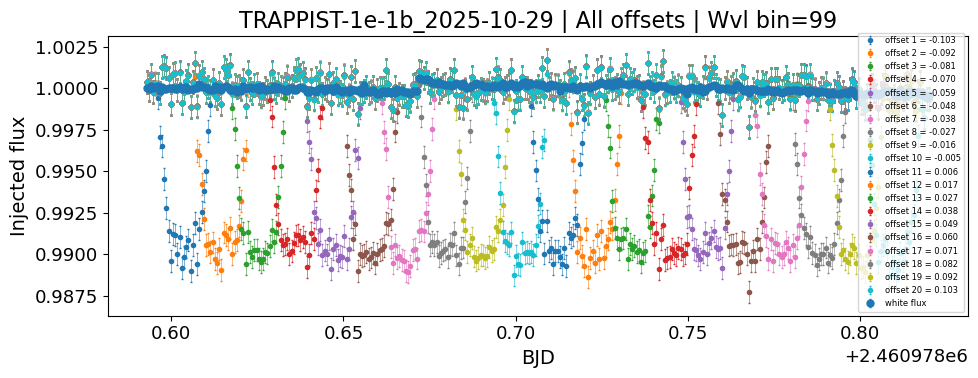

In [21]:
# Inject transit at various times in all bins and plot for selected light curves

for key, d in data_dict_flares_new.items():
    # Mask out the transit for binned data
    it_index = d['it_index'].copy()

    padding = 7
    transit_indices = np.where(it_index == 1)[0]

    for t_idx in transit_indices:
        start = max(0, t_idx - padding)
        end = min(len(it_index), t_idx + padding + 1) 
        it_index[start:t_idx] = 1
        it_index[t_idx + 1:end] = 1

        # Get the out-of-transit bjd times
        bjd_binned_masked = d['bjd_binned'][it_index == 0]
        flux_binned_masked = d['flux_binned'][it_index == 0]
        flux_err_binned_masked = d['flux_err_binned'][it_index == 0]
        white_binned_masked = d['white_binned'][it_index == 0]
        white_err_binned_masked = d['white_err_binned'][it_index == 0]

        if key == "TRAPPIST-1e-1b_2025-10-29":
            # Find transit groups to identify 3rd and 4th transits
            transit_groups = []
            current_group = []
            for i, is_transit in enumerate(it_index):
                if is_transit:
                    current_group.append(i)
                else:
                    if current_group:
                        transit_groups.append(current_group)
                        current_group = []
            if current_group:  # Add last group if it exists
                transit_groups.append(current_group)

            if len(transit_groups) >= 4:
                # Get indices after 3rd transit and before 4th transit
                end_3rd_transit = transit_groups[2][-1]
                start_4th_transit = transit_groups[3][0]
                
                # Create mask for data between 3rd and 4th transits
                between_mask = np.arange(len(d['bjd_binned']))
                between_mask = (between_mask > end_3rd_transit) & (between_mask < start_4th_transit)
                
                # Apply both out-of-transit mask and between-transits mask
                final_mask = (it_index == 0) & between_mask
                
                bjd_binned_masked = d['bjd_binned'][final_mask]
                flux_binned_masked = d['flux_binned'][final_mask]
                flux_err_binned_masked = d['flux_err_binned'][final_mask]
                white_binned_masked = d['white_binned'][final_mask]
                white_err_binned_masked = d['white_err_binned'][final_mask]

    N = 21 # number of offsets
    offset_list= bjd_binned_masked[::int(np.ceil( len(bjd_binned_masked) / N ))] 

    # remove offsets in the edges
    offset_list = offset_list[(offset_list > (bjd_binned_masked.min() + 0.005)) & (offset_list < (bjd_binned_masked.max() - 0.005))]
    
    # remove offsets close to transit
    #bjd_binned_it = d['bjd_binned'][it_index == 1]

    #offset_list = offset_list[(offset_list < (bjd_binned_it.min() - 0.01)) | (offset_list > (bjd_binned_it.max() + 0.01))]
    #print(bjd_binned_it.min(), bjd_binned_it.max())

    offset_list = offset_list - np.mean(bjd_binned_masked)

    #offset_list = [0.02]  # Manually set offsets for testing
    print('Offset list:', offset_list)
    print('Number of offsets:', len(offset_list))

    pl.figure(figsize=(10, 4))
    for jdx, j in enumerate(offset_list):
        
        params = batman.TransitParams()
        params.t0 = np.mean(bjd_binned_masked)+j    #time of inferior conjunction
        params.per = 1.                             #orbital period
        params.a = 15.                              #semi-major axis (in units of stellar radii)
        params.inc = 87.                            #orbital inclination (in degrees)
        params.ecc = 0.                             #eccentricity
        params.w = 90.                              #longitude of periastron (in degrees)
        params.u = [0.1, 0.3]                       #limb darkening coefficients [u1, u2]
        params.limb_dark = "quadratic"              #limb darkening model

        # -----------------------------------------------
        # Inject CHROMATIC transit depths
        # -----------------------------------------------

        # Define chromatic feature
        Rp0 = 0.1            # baseline radius ratio
        A = 0.002            # amplitude of spectral feature  
        lambda0 = 3.5        # center of feature [micron]
        sigma_lambda = 0.3   # width of Gaussian [micron]

        wavelengths = d['wavelength']  # array of wavelength bins

        # Compute chromatic Rp(λ)
        Rp_lambda = Rp0 + A * np.exp(-0.5 * ((wavelengths - lambda0) / sigma_lambda)**2)

        # Inject chromatic transit model
        flux_binned_masked_injected = np.zeros_like(flux_binned_masked)

        for i in range(flux_binned_masked.shape[1]):
            # update transit parameters for this wavelength
            params.rp = Rp_lambda[i]

            m = batman.TransitModel(params, bjd_binned_masked)
            chromatic_flux = m.light_curve(params)

            baseline_mask = (chromatic_flux == 1.0)

            # injection: remove original baseline, add chromatic transit model
            flux_binned_masked_injected[:, i] = (flux_binned_masked[:, i] - np.median(flux_binned_masked[baseline_mask, i]) + chromatic_flux)

        # Plot one wavelength bin for each offset
        for i in np.linspace(100, flux_binned_masked.shape[1] - 100, 1):
            pl.errorbar(bjd_binned_masked, flux_binned_masked_injected[:, int(i) - 1], 
                        flux_err_binned_masked[:, int(i) - 1],
                        fmt='o', capsize=0.4, markersize=3, elinewidth=0.4, 
                        label=f'offset {jdx+1} = {j:.3f}')

    # Plot white flux once
    pl.errorbar(bjd_binned_masked, white_binned_masked, white_err_binned_masked, 
                fmt='o', capsize=0.5, markersize=5, elinewidth=0.5, label='white flux')
    pl.title(f"{key} | All offsets | Wvl bin={int(i) - 1}")
    pl.xlabel('BJD')
    pl.ylabel('Injected flux')
    pl.legend(fontsize=6, loc='lower right')
    pl.tight_layout()
    pl.show()

In [23]:
# Interactive Plotting with Plotly to visually inspect the light curves

from plotly.offline import iplot

import plotly.graph_objs as go


for key, d in data_dict_flares_new.items():
    halpha_wavelength = 0.6563 # microns
    halpha_bin = np.argmin(np.abs(d['wavelength'] - halpha_wavelength))
    
    # Mask out the transit for binned data
    it_index = d['it_index'].copy()
    padding = 7
    transit_indices = np.where(it_index == 1)[0]

    for t_idx in transit_indices:
        start = max(0, t_idx - padding)
        end = min(len(it_index), t_idx + padding + 1)
        it_index[start:t_idx] = 1
        it_index[t_idx + 1:end] = 1

    bjd_binned_masked = d['bjd_binned'][it_index == 0]
    flux_binned_masked = d['flux_binned'][it_index == 0]
    white_binned_masked = d['white_binned'][it_index == 0]
    white_err_binned_masked = d['white_err_binned'][it_index == 0]
    flux_err_binned_masked = d['flux_err_binned'][it_index == 0]

    if key == "TRAPPIST-1e-1b_2025-10-29":
        # Find transit groups to identify 3rd and 4th transits
        transit_groups = []
        current_group = []
        for i, is_transit in enumerate(it_index):
            if is_transit:
                current_group.append(i)
            else:
                if current_group:
                    transit_groups.append(current_group)
                    current_group = []
        if current_group:  # Add last group if it exists
            transit_groups.append(current_group)

        if len(transit_groups) >= 4:
            # Get indices after 3rd transit and before 4th transit
            end_3rd_transit = transit_groups[2][-1]
            start_4th_transit = transit_groups[3][0]
            
            # Create mask for data between 3rd and 4th transits
            between_mask = np.arange(len(d['bjd_binned']))
            between_mask = (between_mask > end_3rd_transit) & (between_mask < start_4th_transit)
            
            # Apply both out-of-transit mask and between-transits mask
            final_mask = (it_index == 0) & between_mask
            
            bjd_binned_masked = d['bjd_binned'][final_mask]
            flux_binned_masked = d['flux_binned'][final_mask]
            flux_err_binned_masked = d['flux_err_binned'][final_mask]
            white_binned_masked = d['white_binned'][final_mask]
            white_err_binned_masked = d['white_err_binned'][final_mask]

    trace = go.Scatter(
        x=bjd_binned_masked,
        y=flux_binned_masked[:, halpha_bin],
        error_y=dict(type='data', array=flux_err_binned_masked[:, halpha_bin], visible=True),
        mode='markers+lines',
        marker=dict(size=6),
        name='H-alpha light curve'
    )

    layout = go.Layout(
        title=f'{key} - Interactive Light Curve',
        xaxis=dict(title='Time [BJD]'),
        yaxis=dict(title='Relative Flux'),
        hovermode='closest'
    )

    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)

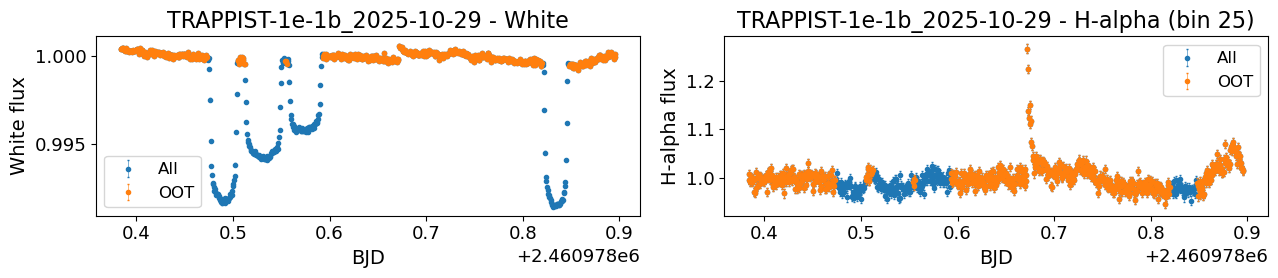

H-alpha bin index: 25, wavelength: 0.6568794250488281 microns


In [24]:
# Plot both white flux and H-alpha flux for each light curve

n_lc = len(data_dict_flares_new)
ncols = 2  # One column for white, one for H-alpha
nrows = n_lc

fig, axes = pl.subplots(nrows, ncols, figsize=(13, 3 * n_lc), sharex=False)
if n_lc == 1:
    axes = axes.reshape(1, 2)

for idx, (key, d) in enumerate(data_dict_flares_new.items()):
    # Find the H-alpha bin index closest to 0.6563 microns
    halpha_wavelength = 0.6563
    halpha_bin = np.argmin(np.abs(d['wavelength'] - halpha_wavelength))
    
    # Mask out the transit for binned data
    it_index = d['it_index'].copy()
    padding = 7
    transit_indices = np.where(it_index == 1)[0]
    for t_idx in transit_indices:
        start = max(0, t_idx - padding)
        end = min(len(it_index), t_idx + padding + 1)
        it_index[start:t_idx] = 1
        it_index[t_idx + 1:end] = 1

    bjd_binned_masked = d['bjd_binned'][it_index == 0]
    white_binned_masked = d['white_binned'][it_index == 0]
    white_err_binned_masked = d['white_err_binned'][it_index == 0]
    flux_binned_masked = d['flux_binned'][it_index == 0]
    flux_err_binned_masked = d['flux_err_binned'][it_index == 0]

    # White flux plot
    ax_white = axes[idx, 0]
    ax_white.errorbar(d['bjd_binned'], d['white_binned'], yerr=d['white_err_binned'],
                      fmt='o', capsize=0.4, markersize=3, elinewidth=0.4, zorder=0, label='All')
    ax_white.errorbar(bjd_binned_masked, white_binned_masked, yerr=white_err_binned_masked, 
                      fmt='o', capsize=0.4, markersize=3, elinewidth=0.4, label='OOT')
    ax_white.set_title(f"{key} - White")
    ax_white.set_xlabel("BJD")
    ax_white.set_ylabel("White flux")
    ax_white.legend()

    # H-alpha flux plot
    ax_halpha = axes[idx, 1]
    ax_halpha.errorbar(d['bjd_binned'], d['flux_binned'][:, halpha_bin], yerr=d['flux_err_binned'][:, halpha_bin],
                       fmt='o', capsize=0.4, markersize=3, elinewidth=0.4, zorder=0, label='All')
    ax_halpha.errorbar(bjd_binned_masked, flux_binned_masked[:, halpha_bin], yerr=flux_err_binned_masked[:, halpha_bin], 
                       fmt='o', capsize=0.4, markersize=3, elinewidth=0.4, label='OOT')
    ax_halpha.set_title(f"{key} - H-alpha (bin {halpha_bin})")
    ax_halpha.set_xlabel("BJD")
    ax_halpha.set_ylabel("H-alpha flux")
    ax_halpha.legend()

pl.tight_layout()
pl.show()

print(f"H-alpha bin index: {halpha_bin}, wavelength: {d['wavelength'][halpha_bin]} microns")


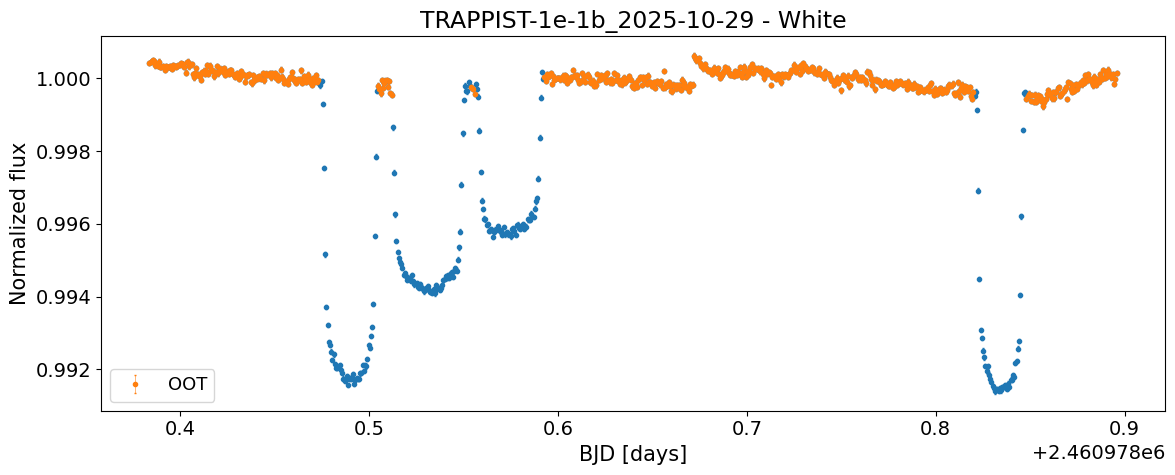

In [32]:
# Plot white flux for each light curve

n_lc = len(data_dict_flares_new)

fig, axes = pl.subplots(n_lc, 1, figsize=(12, 5 * n_lc), sharex=False)
if n_lc == 1:
    axes = [axes]

for idx, (key, d) in enumerate(data_dict_flares_new.items()):
    # Mask out the transit for binned data
    it_index = d['it_index'].copy()
    padding = 7
    transit_indices = np.where(it_index == 1)[0]
    for t_idx in transit_indices:
        start = max(0, t_idx - padding)
        end = min(len(it_index), t_idx + padding + 1)
        it_index[start:t_idx] = 1
        it_index[t_idx + 1:end] = 1

    bjd_binned_masked = d['bjd_binned'][it_index == 0]
    white_binned_masked = d['white_binned'][it_index == 0]
    white_err_binned_masked = d['white_err_binned'][it_index == 0]

    # White flux plot
    ax_white = axes[idx]
    ax_white.errorbar(d['bjd_binned'], d['white_binned'], yerr=d['white_err_binned'],
                      fmt='o', capsize=0.4, markersize=3, elinewidth=0.4, zorder=0)
    ax_white.errorbar(bjd_binned_masked, white_binned_masked, yerr=white_err_binned_masked, 
                      fmt='o', capsize=0.4, markersize=3, elinewidth=0.4, label='OOT')
    ax_white.set_title(f"{key} - White")
    ax_white.set_xlabel("BJD [days]")
    ax_white.set_ylabel("Normalized flux")
    ax_white.legend()

pl.tight_layout()
pl.show()


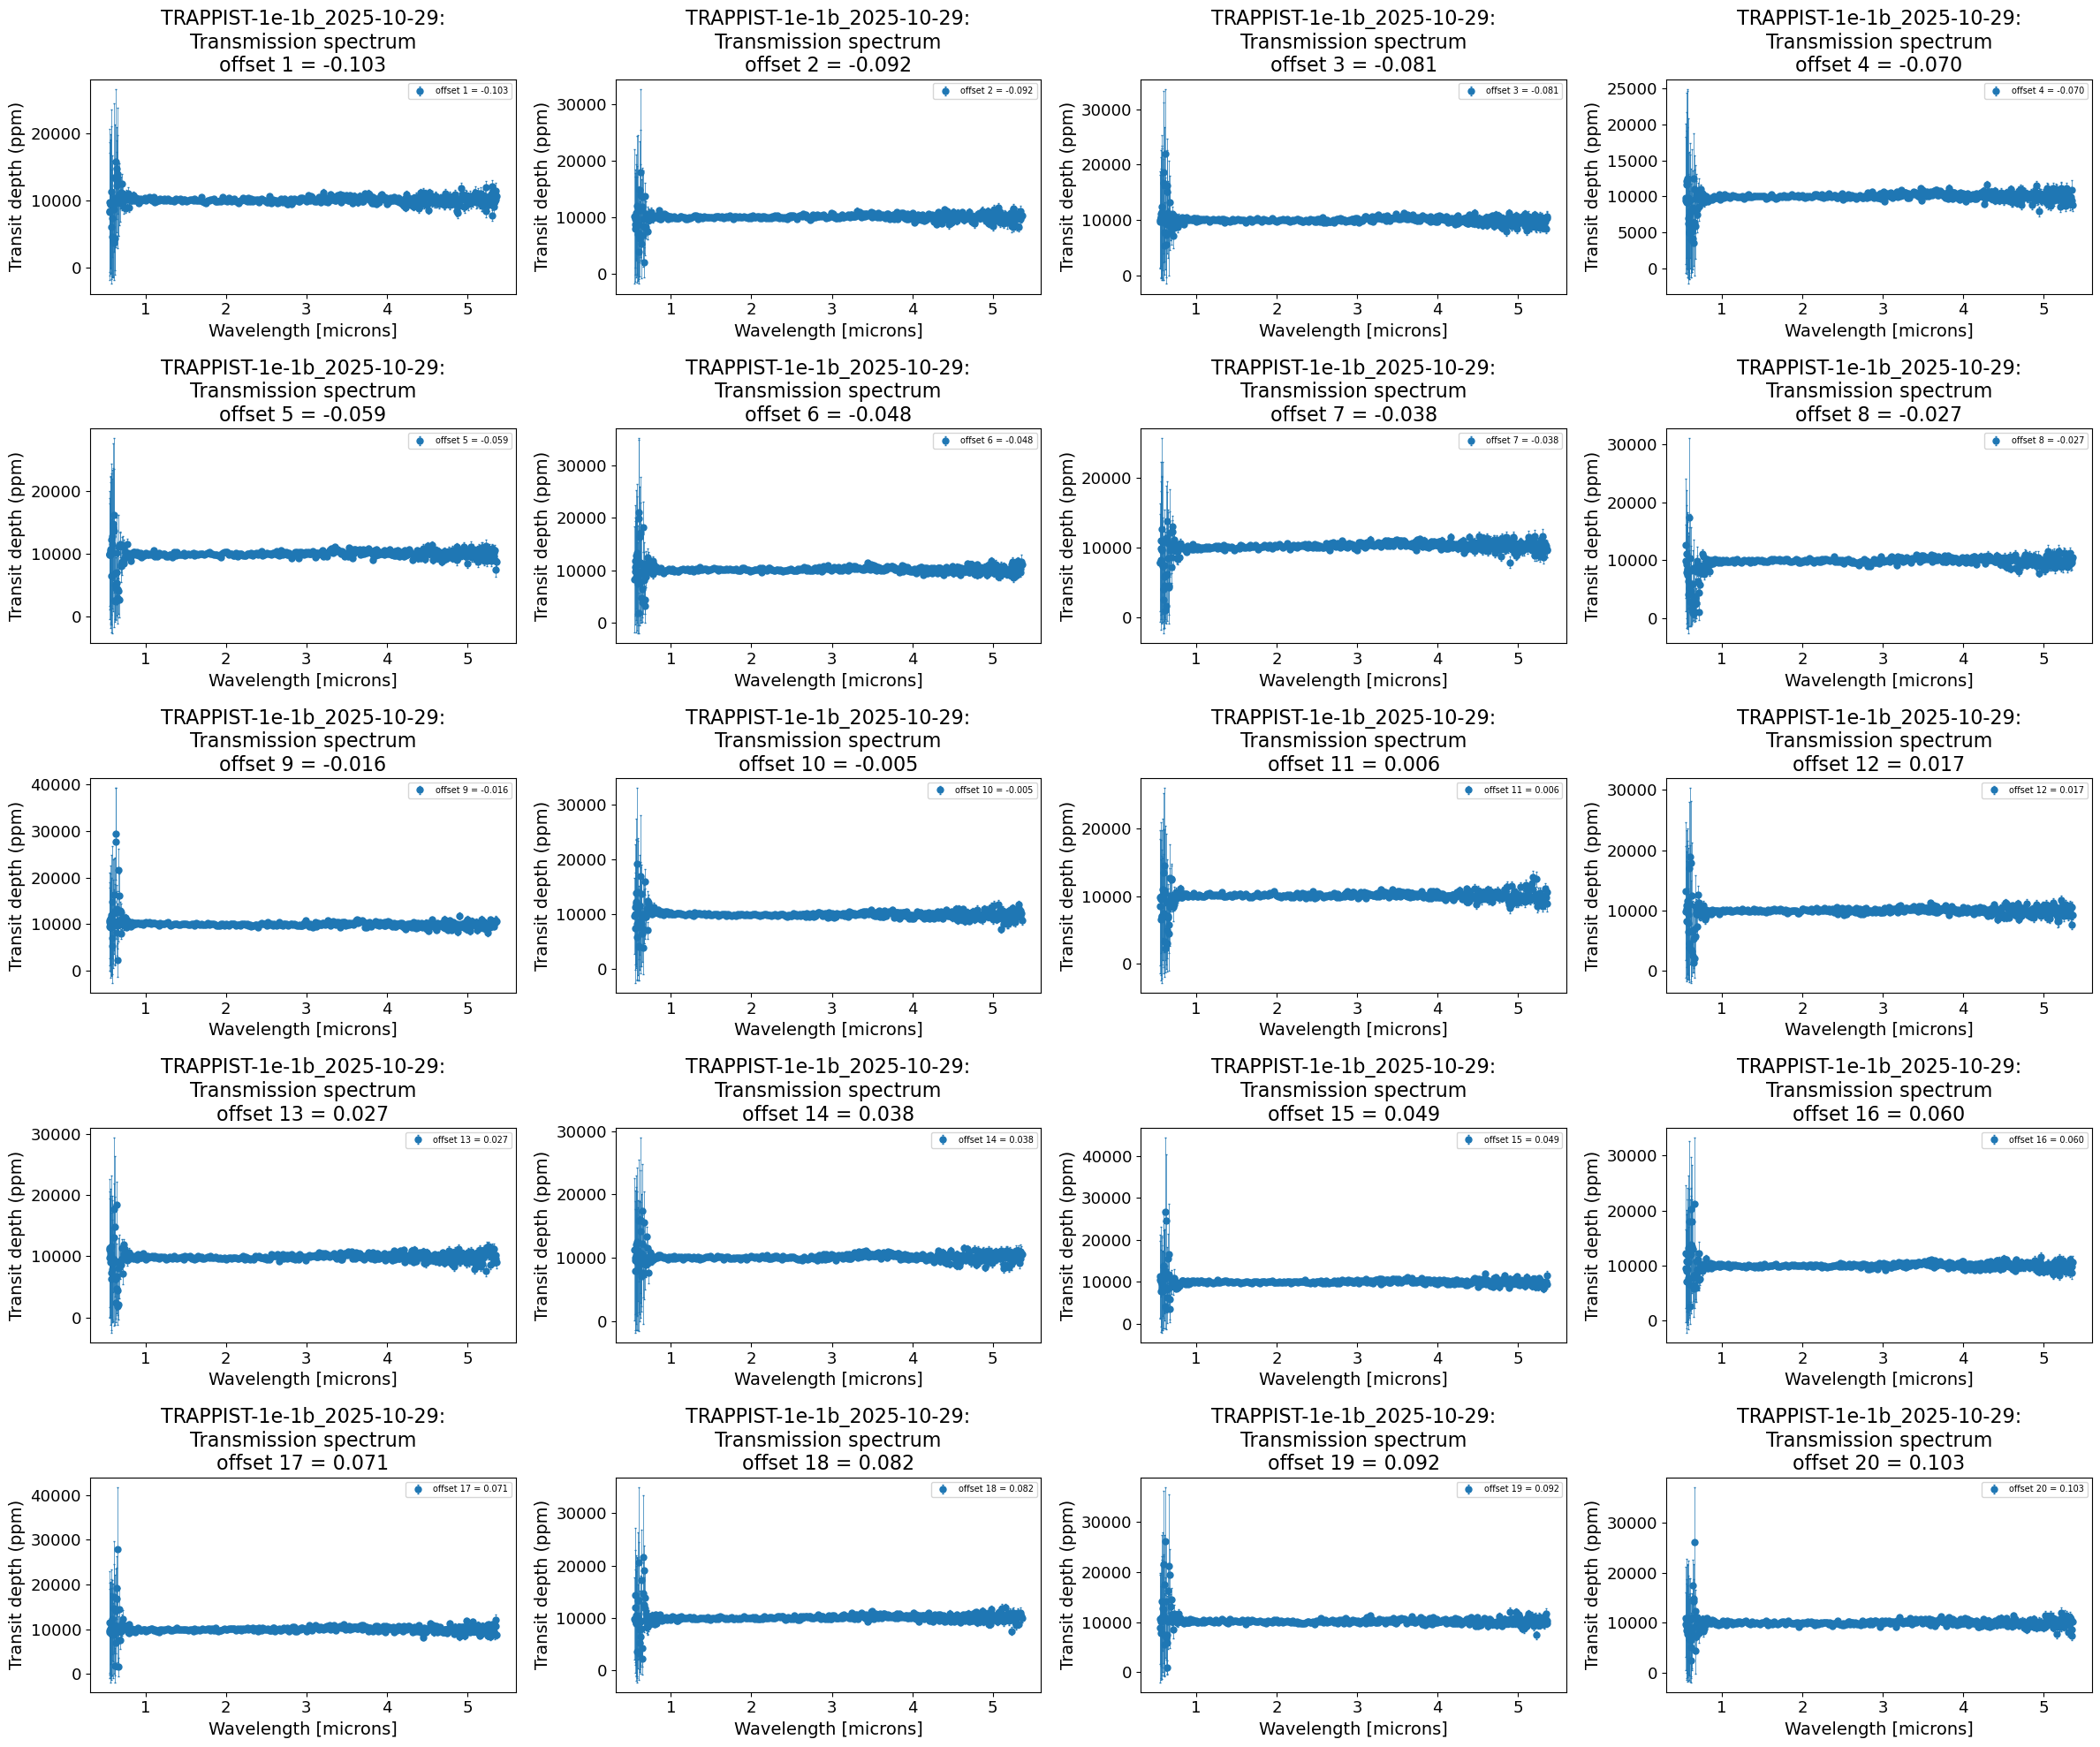

In [26]:
# Plot unbinned transmission spectrum results for all offsets

wvl_bin = 99 # Wavelength bin to plot

n_lc = len(data_dict_flares_new)
n_offsets = len(offset_list)
n_cols = 4
n_rows = int(np.ceil(n_offsets / n_cols)) * n_lc

fig, axes = pl.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)

for idx, (key, d) in enumerate(data_dict_flares_new.items()):
    # Mask out the transit for binned data
    it_index = d['it_index'].copy()
    padding = 7
    transit_indices = np.where(it_index == 1)[0]
    for t_idx in transit_indices:
        start = max(0, t_idx - padding)
        end = min(len(it_index), t_idx + padding + 1)
        it_index[start:t_idx] = 1
        it_index[t_idx + 1:end] = 1

    bjd_binned_masked = d['bjd_binned'][it_index == 0]
    flux_binned_masked = d['flux_binned'][it_index == 0]
    white_binned_masked = d['white_binned'][it_index == 0]
    white_err_binned_masked = d['white_err_binned'][it_index == 0]
    flux_err_binned_masked = d['flux_err_binned'][it_index == 0]
    wavelength = d['wavelength']

    if key == "TRAPPIST-1e-1b_2025-10-29":
        # Find transit groups to identify 3rd and 4th transits
        transit_groups = []
        current_group = []
        for i, is_transit in enumerate(it_index):
            if is_transit:
                current_group.append(i)
            else:
                if current_group:
                    transit_groups.append(current_group)
                    current_group = []
        if current_group:  # Add last group if it exists
            transit_groups.append(current_group)

        if len(transit_groups) >= 4:
            # Get indices after 3rd transit and before 4th transit
            end_3rd_transit = transit_groups[2][-1]
            start_4th_transit = transit_groups[3][0]
            
            # Create mask for data between 3rd and 4th transits
            between_mask = np.arange(len(d['bjd_binned']))
            between_mask = (between_mask > end_3rd_transit) & (between_mask < start_4th_transit)
            
            # Apply both out-of-transit mask and between-transits mask
            final_mask = (it_index == 0) & between_mask
            
            bjd_binned_masked = d['bjd_binned'][final_mask]
            flux_binned_masked = d['flux_binned'][final_mask]
            flux_err_binned_masked = d['flux_err_binned'][final_mask]
            white_binned_masked = d['white_binned'][final_mask]
            white_err_binned_masked = d['white_err_binned'][final_mask]

    for jdx, j in enumerate(offset_list):
        output_filename = f'outputs/mcmc_results_{key}_{j:.5f}_gp_feature.txt'
        data = np.loadtxt(output_filename, delimiter=',', skiprows=1)
        rp_fits = data[:, 0]
        rp_errs = data[:, 1]
        slope_fits = data[:, 2]
        slope_errs = data[:, 3]
        intercept_fits = data[:, 4]
        intercept_errs = data[:, 5]
        tpeak_fits = data[:, 6]
        tpeak_errs = data[:, 7]
        fwhm_fits = data[:, 8]
        fwhm_errs = data[:, 9]
        ampl_fits = data[:, 10]
        ampl_errs = data[:, 11]  
        sigma_fits = data[:, 12]
        sigma_errs = data[:, 13]
        l_fits = data[:, 14]
        l_errs = data[:, 15]

        # Transmission spectrum
        mask = ~np.isnan(wavelength)
        wl_masked = wavelength[mask]
        rp_masked = rp_fits[mask]
        rp_err_masked = rp_errs[mask]

        depth = rp_masked ** 2 * 1e6
        depth_err = 2 * rp_masked * rp_err_masked * 1e6

        row = idx * n_rows // n_lc + jdx // n_cols
        col = jdx % n_cols
        ax = axes[row, col]
        ax.errorbar(wl_masked, depth, yerr=depth_err,
                    fmt='o', capsize=0.5, markersize=5, elinewidth=0.5, label=f'offset {jdx+1} = {j:.3f}')
        ax.set_xlabel('Wavelength [microns]')
        ax.set_ylabel('Transit depth (ppm)')
        ax.set_title(f'{key}:\nTransmission spectrum\noffset {jdx+1} = {j:.3f}')
        ax.legend(fontsize=7)

pl.tight_layout()
pl.show()

In [27]:
# --- Statistical evaluation using Nested Sampling (Ultranest) ---

# Helper context manager to silence stdout/stderr & warnings
from contextlib import redirect_stdout, redirect_stderr, contextmanager

@contextmanager
def silence_all():
    """Context manager that silences stdout, stderr, warnings, numpy floating warnings,
    and lowers ultranest logging. Use around the sampler.run(...) call."""
    # save state
    devnull = open(os.devnull, "w")
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    old_warn_filters = warnings.filters[:]  # copy current filters
    old_log_levels = {}
    # target loggers to quiet (ultranest prints via its own logger & via stdout)
    targets = ['ultranest', 'matplotlib', 'numba', 'parso']  # add others if needed
    for name in targets:
        old_log_levels[name] = logging.getLogger(name).level
        logging.getLogger(name).setLevel(logging.CRITICAL)

    old_errstate = np.seterr()         # numpy error handling
    try:
        # redirect stdout/stderr
        sys.stdout = devnull
        sys.stderr = devnull
        # silence python warnings
        warnings.simplefilter("ignore")
        # silence numpy floating warnings too
        np.seterr(all='ignore')
        yield
    finally:
        # restore
        sys.stdout = old_stdout
        sys.stderr = old_stderr
        warnings.filters = old_warn_filters
        np.seterr(**old_errstate)
        for name, lvl in old_log_levels.items():
            logging.getLogger(name).setLevel(lvl)
        devnull.close()

# --- Define nested sampling functions ---
def run_nested_flat(depth, depth_err):
    """
    depth: 1D array of transit depths (ppm)
    depth_err: 1D array uncertainties (ppm)
    returns: (logZ, logZ_err, result_dict_from_ultranest)
    """
    mean_depth = np.mean(depth)
    sd = np.std(depth)
    # priors for flat model: m ~ Uniform(min-5sigma, max+5sigma)
    m_min = np.min(depth) - 5.0 * max(sd, 1e-6)
    m_max = np.max(depth) + 5.0 * max(sd, 1e-6)

    def prior_transform(u):
        u = np.atleast_1d(u)
        if u.ndim == 1:
            return np.array([m_min + u[0] * (m_max - m_min)])
        else:
            return np.array([m_min + u[:, 0] * (m_max - m_min)]).T

    def loglike(params):
        m = params[0]
        resid = depth - m
        invvar = 1.0 / (depth_err ** 2)
        return -0.5 * np.sum(resid * resid * invvar + np.log(2.0 * np.pi / invvar))
    
    with silence_all():
        sampler = ultranest.ReactiveNestedSampler(['m'], loglike, prior_transform)
        res = sampler.run(min_num_live_points=400, dlogz=0.5, show_status=False, viz_callback=False)

    return res['logz'], res['logzerr'], res


def run_nested_gaussian(wl, depth, depth_err):
    """
    depth: 1D array of transit depths (ppm)
    depth_err: 1D array uncertainties (ppm)
    wl: wavelength array (same length as depth)
    gaussian feature model: depth = baseline + amplitude * exp(-0.5 * ((wl - center) / sigma)^2)
    returns: (logZ, logZ_err, result_dict_from_ultranest)
    """
    mean_depth = np.mean(depth)
    sd = np.std(depth)
    wl_min = np.min(wl)
    wl_max = np.max(wl)
    wl_range = wl_max - wl_min
    
    # Prior bounds
    baseline_min = mean_depth - 10.0 * max(sd, 1e-6)
    baseline_max = mean_depth + 10.0 * max(sd, 1e-6)
    amplitude_min = 0.0  # Only allow emission features (positive amplitude)
    amplitude_max = 5.0 * max(sd, 1e-6)
    center_min = wl_min
    center_max = wl_max
    sigma_min = 0.01 * wl_range  # Minimum width
    sigma_max = 0.25 * wl_range   # Maximum width

    def prior_transform(u):
        u = np.atleast_1d(u)
        if u.ndim == 1:
            baseline = baseline_min + u[0] * (baseline_max - baseline_min)
            amplitude = amplitude_min + u[1] * (amplitude_max - amplitude_min)
            center = center_min + u[2] * (center_max - center_min)
            sigma = sigma_min + u[3] * (sigma_max - sigma_min)
            return np.array([baseline, amplitude, center, sigma])
        else:
            baseline = baseline_min + u[:, 0] * (baseline_max - baseline_min)
            amplitude = amplitude_min + u[:, 1] * (amplitude_max - amplitude_min)
            center = center_min + u[:, 2] * (center_max - center_min)
            sigma = sigma_min + u[:, 3] * (sigma_max - sigma_min)
            return np.stack([baseline, amplitude, center, sigma], axis=-1)

    def loglike(params):
        baseline, amplitude, center, sigma = params
        model = baseline + amplitude * np.exp(-0.5 * ((wl - center) / sigma) ** 2)
        resid = depth - model
        invvar = 1.0 / (depth_err ** 2)
        return -0.5 * np.sum(resid * resid * invvar + np.log(2.0 * np.pi / invvar))

    with silence_all():
        sampler = ultranest.ReactiveNestedSampler(['baseline', 'amplitude', 'center', 'sigma'], loglike, prior_transform)
        res = sampler.run(min_num_live_points=400, dlogz=0.5, show_status=False, viz_callback=False)
    
    return res['logz'], res['logzerr'], res


# --- Main evaluation loop ---
# Create directory for nested sampling results
os.makedirs(f'outputs/nested_results_feature/{key}', exist_ok=True)

for idx, (key, d) in enumerate(data_dict_flares_new.items()):
    print(f"\nEvaluation of results for {key} (unbinned spectra)")

    wavelength = d['wavelength']
    mask = ~np.isnan(wavelength)
    wl_masked = wavelength[mask]

    slice_start, slice_end = 55, len(wl_masked) - 40
    wl_masked_sliced = wl_masked[slice_start:slice_end]

    if idx == 0:
        all_results_nested = {}

    if key not in all_results_nested:
        all_results_nested[key] = []

    for jdx, j in enumerate(offset_list):
        # --- File names for all models ---
        if key == "TRAPPIST-1e_2023-06-22":
            output_filename_gp = f'outputs/mcmc_results_{key}_{j:.5f}_gp_feature.txt'
            nested_results_file = f'outputs/nested_results_feature/{key}/{key}_{j:.5f}_nested_feature.pkl'
        else:
            output_filename_gp = f'outputs/mcmc_results_{key}_{j:.5f}_gp_feature.txt'
            nested_results_file = f'outputs/nested_results_feature/{key}/{key}_{j:.5f}_nested_feature.pkl'

        # Check if results already exist
        if os.path.exists(nested_results_file):
            print(f"Loading existing nested sampling results for offset {jdx+1} = {j:.3f}")
            with open(nested_results_file, 'rb') as f:
                offset_results = pickle.load(f)
        else:
            # --- Helper to load and slice results ---
            def load_results(filename, mask, slice_start, slice_end):
                data = np.loadtxt(filename, delimiter=',', skiprows=1)
                rp, rp_err = data[:, 0], data[:, 1]
                rp_masked = rp[mask][slice_start:slice_end]
                rp_err_masked = rp_err[mask][slice_start:slice_end]
                return rp_masked, rp_err_masked

            # --- Load all three models ---
            rp_masked_gp, rp_err_masked_gp = load_results(output_filename_gp, mask, slice_start, slice_end)

            wl = wl_masked_sliced

            models = {"+ gp": (rp_masked_gp, rp_err_masked_gp)}

            # Dictionary to store results for this offset
            offset_results = {"Offset": f"offset {jdx+1} = {j:.3f}"}

            # --- Run for each model type ---
            for model_name, (rp_masked, rp_err_masked) in models.items():
                depth = rp_masked ** 2 * 1e6
                depth_err = 2 * rp_masked * rp_err_masked * 1e6

                logz_flat, logzflat_err, res_flat = run_nested_flat(depth, depth_err)
                logz_gauss, logzgauss_err, res_gauss = run_nested_gaussian(wl, depth, depth_err)
                delta_logz = logz_gauss - logz_flat

                # --- Jeffreys scale interpretation ---
                if delta_logz > 5:
                    interpretation = "Non-flat (Gaussian): strong evidence"
                    preferred_model = "gaussian"
                elif delta_logz > 2:
                    interpretation = "Non-flat (Gaussian): moderate evidence"
                    preferred_model = "gaussian"
                elif delta_logz > 1:
                    interpretation = "Non-flat (Gaussian): weak evidence"
                    preferred_model = "gaussian"
                elif delta_logz < -1:
                    interpretation = "Flat: weak evidence"
                    preferred_model = "flat"
                elif delta_logz < -2:
                    interpretation = "Flat: moderate evidence"
                    preferred_model = "flat"
                elif delta_logz < -5:
                    interpretation = "Flat: strong evidence"
                    preferred_model = "flat"
                else:
                    interpretation = "Inconclusive"
                    preferred_model = "inconclusive"

                # Store results (ΔlogZ and interpretation first)
                offset_results[f"ΔlogZ ({model_name})"] = delta_logz
                offset_results[f"Interpretation ({model_name})"] = interpretation
                
                # Store model parameters separately (will be reordered later)
                if preferred_model == "gaussian":
                    # Get median and std from posterior samples
                    samples = res_gauss['samples']
                    baseline_median = np.median(samples[:, 0])
                    baseline_std = np.std(samples[:, 0])
                    amplitude_median = np.median(samples[:, 1])
                    amplitude_std = np.std(samples[:, 1])
                    center_median = np.median(samples[:, 2])
                    center_std = np.std(samples[:, 2])
                    sigma_median = np.median(samples[:, 3])
                    sigma_std = np.std(samples[:, 3])
                    
                    offset_results[f"Baseline ({model_name})"] = baseline_median
                    offset_results[f"Baseline_err ({model_name})"] = baseline_std
                    offset_results[f"Amplitude ({model_name})"] = amplitude_median
                    offset_results[f"Amplitude_err ({model_name})"] = amplitude_std
                    offset_results[f"Center ({model_name})"] = center_median
                    offset_results[f"Center_err ({model_name})"] = center_std
                    offset_results[f"Sigma ({model_name})"] = sigma_median
                    offset_results[f"Sigma_err ({model_name})"] = sigma_std
                    
                elif preferred_model == "flat" or preferred_model == "inconclusive":
                    # Get median and std from posterior samples
                    samples = res_flat['samples']
                    mean_depth_median = np.median(samples[:, 0])
                    mean_depth_std = np.std(samples[:, 0])
                    
                    offset_results[f"Mean_Depth ({model_name})"] = mean_depth_median
                    offset_results[f"Mean_Depth_err ({model_name})"] = mean_depth_std

            # Save results
            with open(nested_results_file, 'wb') as f:
                pickle.dump(offset_results, f)

        all_results_nested[key].append(offset_results)

    # --- Display summary table for this light curve with reordered columns ---
    table = pd.DataFrame(all_results_nested[key])
    
    # Reorder columns: Offset, then ΔlogZ and Interpretation columns, then model parameters
    cols = list(table.columns)
    main_cols = ['Offset']
    delta_interp_cols = [c for c in cols if 'ΔlogZ' in c or 'Interpretation' in c]
    param_cols = [c for c in cols if c not in main_cols and c not in delta_interp_cols]
    
    table = table[main_cols + delta_interp_cols + param_cols]
    
    display(table)


Evaluation of results for TRAPPIST-1e-1b_2025-10-29 (unbinned spectra)
Loading existing nested sampling results for offset 1 = -0.103
Loading existing nested sampling results for offset 2 = -0.092
Loading existing nested sampling results for offset 3 = -0.081
Loading existing nested sampling results for offset 4 = -0.070
Loading existing nested sampling results for offset 5 = -0.059
Loading existing nested sampling results for offset 6 = -0.048
Loading existing nested sampling results for offset 7 = -0.038
Loading existing nested sampling results for offset 8 = -0.027
Loading existing nested sampling results for offset 9 = -0.016
Loading existing nested sampling results for offset 10 = -0.005
Loading existing nested sampling results for offset 11 = 0.006
Loading existing nested sampling results for offset 12 = 0.017
Loading existing nested sampling results for offset 13 = 0.027
Loading existing nested sampling results for offset 14 = 0.038
Loading existing nested sampling results for 

Offset  ΔlogZ (+ gp)                   Interpretation (+ gp)  \
0    offset 1 = -0.103      7.072103    Non-flat (Gaussian): strong evidence   
1    offset 2 = -0.092     17.312881    Non-flat (Gaussian): strong evidence   
2    offset 3 = -0.081     32.576497    Non-flat (Gaussian): strong evidence   
3    offset 4 = -0.070     22.007897    Non-flat (Gaussian): strong evidence   
4    offset 5 = -0.059     23.018896    Non-flat (Gaussian): strong evidence   
5    offset 6 = -0.048     25.030441    Non-flat (Gaussian): strong evidence   
6    offset 7 = -0.038     45.164131    Non-flat (Gaussian): strong evidence   
7    offset 8 = -0.027     22.025613    Non-flat (Gaussian): strong evidence   
8    offset 9 = -0.016      6.267414    Non-flat (Gaussian): strong evidence   
9   offset 10 = -0.005      4.046316  Non-flat (Gaussian): moderate evidence   
10   offset 11 = 0.006      3.280344  Non-flat (Gaussian): moderate evidence   
11   offset 12 = 0.017     13.608908    Non-flat (Gaussian): strong evidence   
12   offset 13 = 0.027     31.500052    Non-flat (Gaussian): strong evidence   
13   offset 14 = 0.038     35.267052    Non-flat (Gaussian): strong evidence   
14   offset 15 = 0.049     22.301921    Non-flat (Gaussian): strong evidence   
15   offset 16 = 0.060     24.271118    Non-flat (Gaussian): strong evidence   
16   offset 17 = 0.071     38.884814    Non-flat (Gaussian): strong evidence   
17   offset 18 = 0.082     31.447656    Non-flat (Gaussian): strong evidence   
18   offset 19 = 0.092      5.242752    Non-flat (Gaussian): strong evidence   
19   offset 20 = 0.103     20.309902    Non-flat (Gaussian): strong evidence   

    Baseline (+ gp)  Baseline_err (+ gp)  Amplitude (+ gp)  \
0      10034.697327            19.649315        273.036024   
1       9999.157407            20.041487        338.243616   
2       9955.288910            17.421244        446.159853   
3       9993.984465            18.392953        378.330413   
4       9967.198506            18.540981        350.611098   
5      10108.915533            19.036832        391.873328   
6      10104.126366            20.074623        498.757988   
7       9859.272101            21.142418        425.368839   
8       9981.916062            16.587678        270.419407   
9       9957.915469            16.527587        224.929238   
10     10086.806275            17.394721        187.144056   
11      9944.717532            16.809590        344.737321   
12      9799.206850            19.201945        394.004010   
13     10030.727848            17.868818        483.856434   
14     10011.909926            17.658602        375.922461   
15      9968.719222            17.200785        449.770428   
16      9965.790386            19.475455        451.638092   
17      9989.535771            18.683766        398.099573   
18     10114.382146            18.442525        201.577886   
19      9979.196752            20.836805        416.612464   

    Amplitude_err (+ gp)  Center (+ gp)  Center_err (+ gp)  Sigma (+ gp)  \
0              69.090550       3.536912           0.088003      0.289182   
1              70.871300       3.395996           0.068733      0.311412   
2              58.635119       3.560096           0.048479      0.310415   
3              63.115695       3.536564           0.058156      0.308807   
4              53.092213       3.568948           0.073377      0.409335   
5              57.829173       3.400251           0.058583      0.340692   
6              51.768195       3.540118           0.063688      0.474212   
7              69.216587       3.586450           0.061926      0.294844   
8              75.451379       3.593388           0.064854      0.205860   
9              73.455301       3.487149           0.085129      0.204071   
10             68.596296       3.414989           0.113653      0.267313   
11             66.665035       3.459322           0.054053      0.236683   
12             49.962592       3.480818     

In [28]:
def bin_transmission_spectrum(wl, depth, depth_err, bin_width):
    """
    Bin a transmission spectrum into equal wavelength bins.

    Parameters:
    wl (array): Wavelengths in microns.
    depth (array): Transit depth measurements.
    depth_err (array): Errors on the transit depth measurements.
    bin_width (float): Desired width of each wavelength bin.

    Returns:
    wl_binned (array): Binned wavelength centers.
    depth_binned (array): Binned transit depths.
    depth_err_binned (array): Errors on the binned transit depths.
    """

    # Define bin edges
    wl_min, wl_max = np.min(wl), np.max(wl)
    bins = np.arange(wl_min, wl_max + bin_width, bin_width)
    
    # Initialize lists to store binned results
    wl_binned, depth_binned, depth_err_binned = [], [], []
    
    for i in range(len(bins) - 1):
        mask = (wl >= bins[i]) & (wl < bins[i + 1])
        
        if np.any(mask):  # If there are points in the bin
            wl_bin_center = np.mean(wl[mask])
            
            # Inverse variance weighting for depth
            weights = 1 / (depth_err[mask] ** 2)
            depth_mean = np.sum(weights * depth[mask]) / np.sum(weights)
            depth_err_mean = np.sqrt(1 / np.sum(weights))  # Propagate error
            
            wl_binned.append(wl_bin_center)
            depth_binned.append(depth_mean)
            depth_err_binned.append(depth_err_mean)
    
    return np.array(wl_binned), np.array(depth_binned), np.array(depth_err_binned)

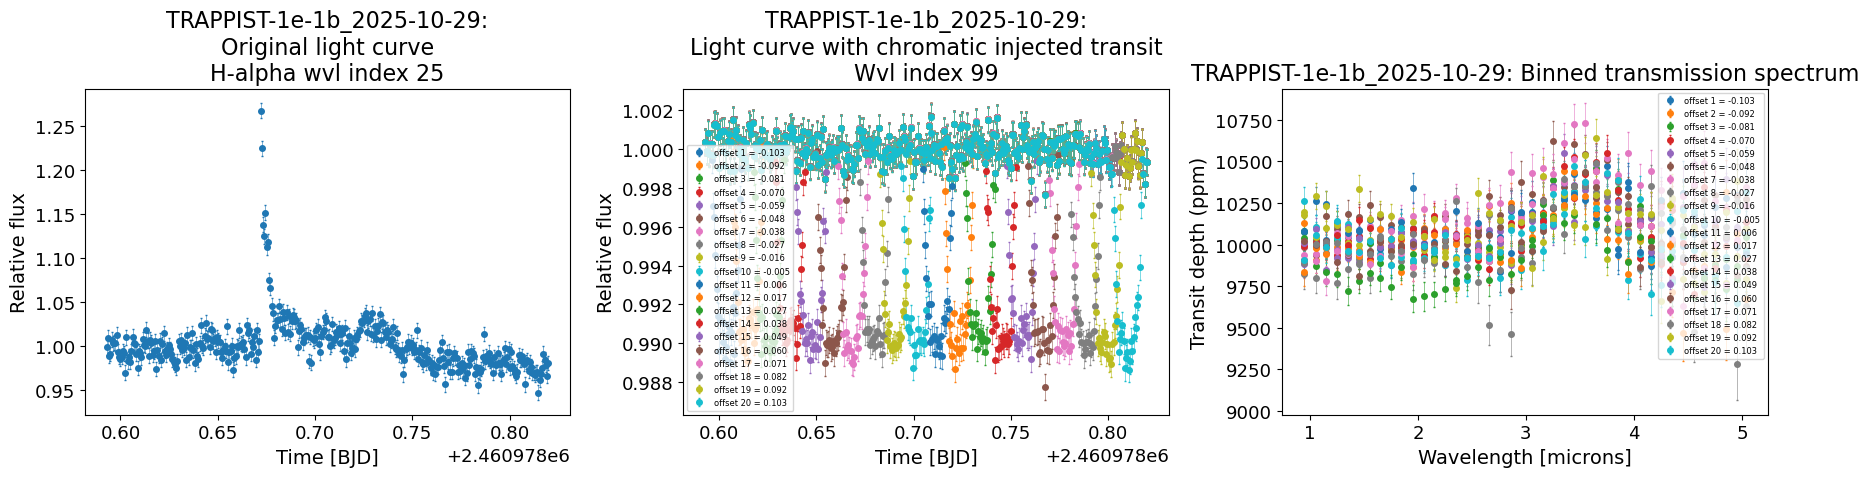

In [29]:
# Plot results in 3 subplots for each selected light curve (all offsets ontop of each other)

wvl_bin = 99 # Wavelength bin to plot

n_lc = len(data_dict_flares_new)
fig, axes = pl.subplots(n_lc, 3, figsize=(18, 5 * n_lc))

if n_lc == 1:
    axes = axes.reshape(1, 3)

for idx, (key, d) in enumerate(data_dict_flares_new.items()):

    halpha_wavelength = 0.6563 # microns
    halpha_bin = np.argmin(np.abs(d['wavelength'] - halpha_wavelength))
    
    # Mask out the transit for binned data
    it_index = d['it_index'].copy()
    padding = 7
    transit_indices = np.where(it_index == 1)[0]

    for t_idx in transit_indices:
        start = max(0, t_idx - padding)
        end = min(len(it_index), t_idx + padding + 1)
        it_index[start:t_idx] = 1
        it_index[t_idx + 1:end] = 1

    bjd_binned_masked = d['bjd_binned'][it_index == 0]
    flux_binned_masked = d['flux_binned'][it_index == 0]
    white_binned_masked = d['white_binned'][it_index == 0]
    white_err_binned_masked = d['white_err_binned'][it_index == 0]
    flux_err_binned_masked = d['flux_err_binned'][it_index == 0]

    if key == "TRAPPIST-1e-1b_2025-10-29":
        # Find transit groups to identify 3rd and 4th transits
        transit_groups = []
        current_group = []
        for i, is_transit in enumerate(it_index):
            if is_transit:
                current_group.append(i)
            else:
                if current_group:
                    transit_groups.append(current_group)
                    current_group = []
        if current_group:  # Add last group if it exists
            transit_groups.append(current_group)

        if len(transit_groups) >= 4:
            # Get indices after 3rd transit and before 4th transit
            end_3rd_transit = transit_groups[2][-1]
            start_4th_transit = transit_groups[3][0]
            
            # Create mask for data between 3rd and 4th transits
            between_mask = np.arange(len(d['bjd_binned']))
            between_mask = (between_mask > end_3rd_transit) & (between_mask < start_4th_transit)
            
            # Apply both out-of-transit mask and between-transits mask
            final_mask = (it_index == 0) & between_mask
            
            bjd_binned_masked = d['bjd_binned'][final_mask]
            flux_binned_masked = d['flux_binned'][final_mask]
            flux_err_binned_masked = d['flux_err_binned'][final_mask]
            white_binned_masked = d['white_binned'][final_mask]
            white_err_binned_masked = d['white_err_binned'][final_mask]

    if key == "TRAPPIST-1e-1b_2025-10-29":
        # Find transit groups to identify 3rd and 4th transits
        transit_groups = []
        current_group = []
        for i, is_transit in enumerate(it_index):
            if is_transit:
                current_group.append(i)
            else:
                if current_group:
                    transit_groups.append(current_group)
                    current_group = []
        if current_group:  # Add last group if it exists
            transit_groups.append(current_group)

        if len(transit_groups) >= 4:
            # Get indices after 3rd transit and before 4th transit
            end_3rd_transit = transit_groups[2][-1]
            start_4th_transit = transit_groups[3][0]
            
            # Create mask for data between 3rd and 4th transits
            between_mask = np.arange(len(d['bjd_binned']))
            between_mask = (between_mask > end_3rd_transit) & (between_mask < start_4th_transit)
            
            # Apply both out-of-transit mask and between-transits mask
            final_mask = (it_index == 0) & between_mask
            
            bjd_binned_masked = d['bjd_binned'][final_mask]
            flux_binned_masked = d['flux_binned'][final_mask]
            flux_err_binned_masked = d['flux_err_binned'][final_mask]
            white_binned_masked = d['white_binned'][final_mask]
            white_err_binned_masked = d['white_err_binned'][final_mask]

    ax1, ax2, ax3 = axes[idx]
    
    # Original light curve at halpha wvl
    ax1.errorbar(bjd_binned_masked, flux_binned_masked[:, halpha_bin], yerr=flux_err_binned_masked[:, halpha_bin], fmt='o', capsize=0.4, markersize=4, elinewidth=0.4)
    ax1.set_xlabel('Time [BJD]')
    ax1.set_ylabel('Relative flux')
    ax1.set_title(f'{key}:\nOriginal light curve\nH-alpha wvl index {halpha_bin}')

    for jdx,j in enumerate(offset_list):

        output_filename = f'outputs/mcmc_results_{key}_{j:.5f}_gp_feature.txt'

        # Load existing results
        data = np.loadtxt(output_filename, delimiter=',', skiprows=1)
        rp_fits = data[:, 0]
        rp_errs = data[:, 1]
        slope_fits = data[:, 2]
        slope_errs = data[:, 3]
        intercept_fits = data[:, 4]
        intercept_errs = data[:, 5]
        tpeak_fits = data[:, 6]
        tpeak_errs = data[:, 7]
        fwhm_fits = data[:, 8]
        fwhm_errs = data[:, 9]
        ampl_fits = data[:, 10]
        ampl_errs = data[:, 11]
        sigma_fits = data[:, 12]
        sigma_errs = data[:, 13]
        l_fits = data[:, 14]
        l_errs = data[:, 15]
        
        params = batman.TransitParams()
        params.t0 = np.mean(bjd_binned_masked)+j    #time of inferior conjunction
        params.per = 1.                             #orbital period
        params.a = 15.                              #semi-major axis (in units of stellar radii)
        params.inc = 87.                            #orbital inclination (in degrees)
        params.ecc = 0.                             #eccentricity
        params.w = 90.                              #longitude of periastron (in degrees)
        params.u = [0.1, 0.3]                       #limb darkening coefficients [u1, u2]
        params.limb_dark = "quadratic"              #limb darkening model

        # -----------------------------------------------
        # Inject CHROMATIC transit depths
        # -----------------------------------------------

        # Define chromatic feature
        Rp0 = 0.1            # baseline radius ratio
        A = 0.002            # amplitude of spectral feature  
        lambda0 = 3.5        # center of feature [micron]
        sigma_lambda = 0.3   # width of Gaussian [micron]

        wavelengths = d['wavelength']  # array of wavelength bins

        # Compute chromatic Rp(λ)
        Rp_lambda = Rp0 + A * np.exp(-0.5 * ((wavelengths - lambda0) / sigma_lambda)**2)

        # Inject chromatic transit model
        flux_binned_masked_injected = np.zeros_like(flux_binned_masked)

        for i in range(flux_binned_masked.shape[1]):
            # update transit parameters for this wavelength
            params.rp = Rp_lambda[i]

            m = batman.TransitModel(params, bjd_binned_masked)
            chromatic_flux = m.light_curve(params)

            baseline_mask = (chromatic_flux == 1.0)

            # injection: remove original baseline, add chromatic transit model
            flux_binned_masked_injected[:, i] = (flux_binned_masked[:, i] - np.median(flux_binned_masked[baseline_mask, i]) + chromatic_flux)


        ax2.errorbar(bjd_binned_masked, flux_binned_masked_injected[:, wvl_bin], yerr=flux_err_binned_masked[:, wvl_bin], 
                     fmt='o', capsize=0.4, markersize=4, elinewidth=0.4, label=f'offset {jdx+1} = {j:.3f}')

        # Transmission spectrum
        mask = ~np.isnan(wavelength)
        wl_masked = wavelength[mask]
        #print('Wvls before slicing:', len(wl_masked))
        rp_masked = rp_fits[mask]
        rp_err_masked = rp_errs[mask]

        # Slice off edges to avoid noisy wvl bins
        slice_start = 55
        slice_end = len(wl_masked) - 40 #slice_start

        wl_masked = wl_masked[slice_start:slice_end]
        #print('Wvls after slicing:', len(wl_masked))
        rp_masked = rp_masked[slice_start:slice_end]
        rp_err_masked = rp_err_masked[slice_start:slice_end]
      
        wl_binned, rp_binned, rp_err_binned = bin_transmission_spectrum(wl_masked, rp_masked, rp_err_masked, bin_width=0.1)
        depth_binned = rp_binned ** 2 * 1e6
        depth_err_binned = 2 * rp_binned * rp_err_binned * 1e6
        ax3.errorbar(wl_binned, depth_binned, yerr=depth_err_binned,
                      fmt='o', capsize=0.4, markersize=4, elinewidth=0.4, label=f'offset {jdx+1} = {j:.3f}')

    ax2.set_xlabel('Time [BJD]')
    ax2.set_ylabel('Relative flux')
    ax2.set_title(f'{key}:\nLight curve with chromatic injected transit\nWvl index {wvl_bin}')
    ax2.legend(fontsize=6)

    ax3.set_xlabel('Wavelength [microns]')
    #ax3.set_ylim(9000, 11000)
    ax3.set_ylabel('Transit depth (ppm)')
    ax3.set_title(f'{key}: Binned transmission spectrum')
    ax3.legend(fontsize=6)

pl.tight_layout()
pl.show()

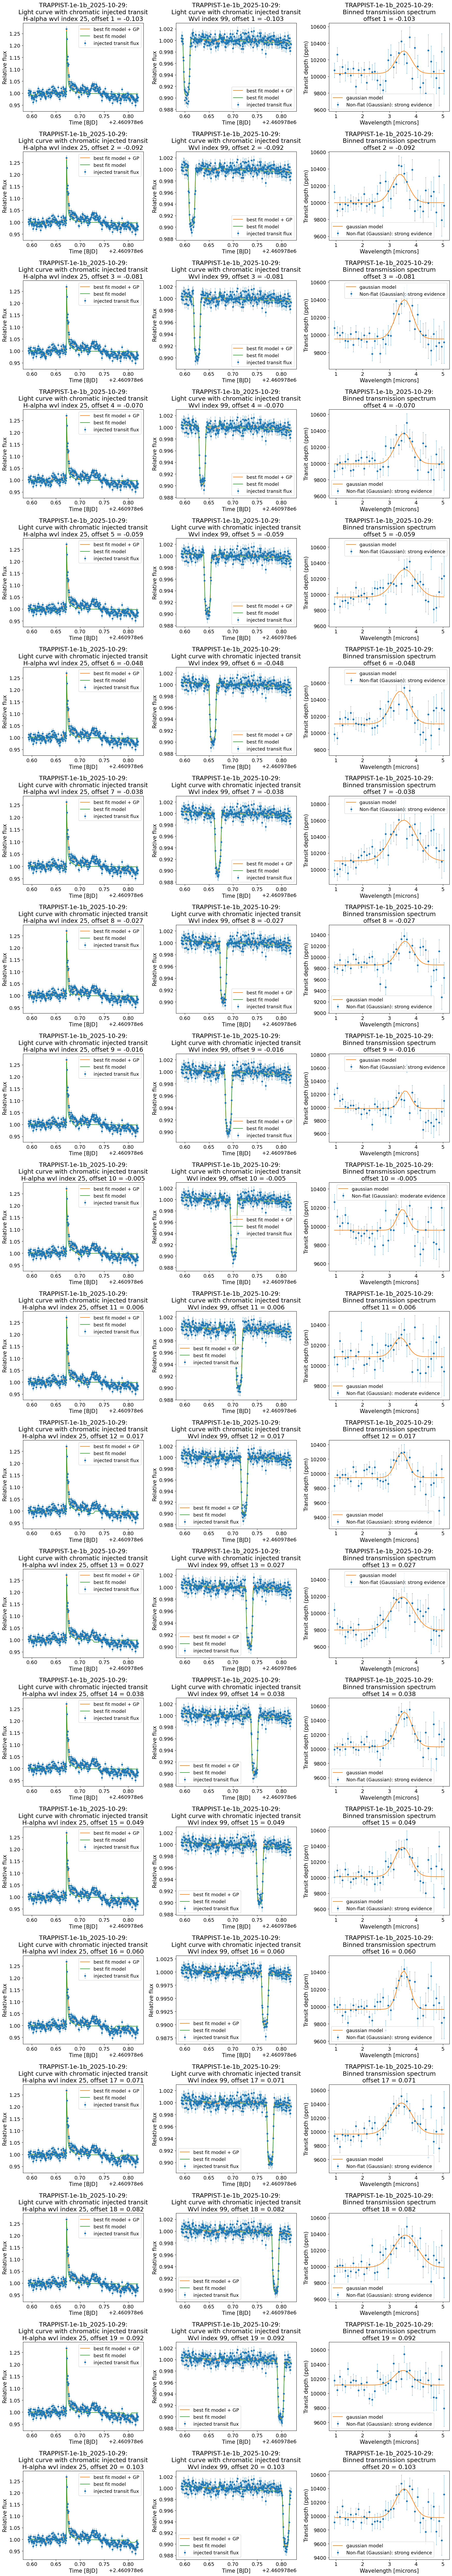

In [33]:
# Plot results in 3 subplots for each selected light curve and each offset

wvl_bin = 99 # Wavelength bin to plot

n_lc = len(data_dict_flares_new)
n_offsets = len(offset_list)
fig, axes = pl.subplots(n_lc * n_offsets, 3, figsize=(18, 5 * n_lc * n_offsets))

if n_lc * n_offsets == 1:
    axes = axes.reshape(1, 3)

plot_idx = 0
for idx, (key, d) in enumerate(data_dict_flares_new.items()):
    # Mask out the transit for binned data
    it_index = d['it_index'].copy()
    padding = 7
    transit_indices = np.where(it_index == 1)[0]

    for t_idx in transit_indices:
        start = max(0, t_idx - padding)
        end = min(len(it_index), t_idx + padding + 1)
        it_index[start:t_idx] = 1
        it_index[t_idx + 1:end] = 1

    bjd_binned_masked = d['bjd_binned'][it_index == 0]
    flux_binned_masked = d['flux_binned'][it_index == 0]
    white_binned_masked = d['white_binned'][it_index == 0]
    white_err_binned_masked = d['white_err_binned'][it_index == 0]
    flux_err_binned_masked = d['flux_err_binned'][it_index == 0]

    if key == "TRAPPIST-1e-1b_2025-10-29":
        # Find transit groups to identify 3rd and 4th transits
        transit_groups = []
        current_group = []
        for i, is_transit in enumerate(it_index):
            if is_transit:
                current_group.append(i)
            else:
                if current_group:
                    transit_groups.append(current_group)
                    current_group = []
        if current_group:  # Add last group if it exists
            transit_groups.append(current_group)

        if len(transit_groups) >= 4:
            # Get indices after 3rd transit and before 4th transit
            end_3rd_transit = transit_groups[2][-1]
            start_4th_transit = transit_groups[3][0]
            
            # Create mask for data between 3rd and 4th transits
            between_mask = np.arange(len(d['bjd_binned']))
            between_mask = (between_mask > end_3rd_transit) & (between_mask < start_4th_transit)
            
            # Apply both out-of-transit mask and between-transits mask
            final_mask = (it_index == 0) & between_mask
            
            bjd_binned_masked = d['bjd_binned'][final_mask]
            flux_binned_masked = d['flux_binned'][final_mask]
            flux_err_binned_masked = d['flux_err_binned'][final_mask]
            white_binned_masked = d['white_binned'][final_mask]
            white_err_binned_masked = d['white_err_binned'][final_mask]

    for jdx,j in enumerate(offset_list):
        
        output_filename = f'outputs/mcmc_results_{key}_{j:.5f}_gp_feature.txt'

        # Load existing results
        data = np.loadtxt(output_filename, delimiter=',', skiprows=1)
        rp_fits = data[:, 0]
        rp_errs = data[:, 1]
        slope_fits = data[:, 2]
        slope_errs = data[:, 3]
        intercept_fits = data[:, 4]
        intercept_errs = data[:, 5]
        tpeak_fits = data[:, 6]
        tpeak_errs = data[:, 7]
        fwhm_fits = data[:, 8]
        fwhm_errs = data[:, 9]
        ampl_fits = data[:, 10]
        ampl_errs = data[:, 11]
        sigma_fits = data[:, 12]
        sigma_errs = data[:, 13]
        l_fits = data[:, 14]
        l_errs = data[:, 15]

        ax1, ax2, ax3 = axes[plot_idx]

        params = batman.TransitParams()
        params.t0 = np.mean(bjd_binned_masked)+j    #time of inferior conjunction
        params.per = 1.                             #orbital period
        params.a = 15.                              #semi-major axis (in units of stellar radii)
        params.inc = 87.                            #orbital inclination (in degrees)
        params.ecc = 0.                             #eccentricity
        params.w = 90.                              #longitude of periastron (in degrees)
        params.u = [0.1, 0.3]                       #limb darkening coefficients [u1, u2]
        params.limb_dark = "quadratic"              #limb darkening model

        # -----------------------------------------------
        # Inject CHROMATIC transit depths
        # -----------------------------------------------

        # Define chromatic feature
        Rp0 = 0.1            # baseline radius ratio
        A = 0.002            # amplitude of spectral feature  
        lambda0 = 3.5        # center of feature [micron]
        sigma_lambda = 0.3   # width of Gaussian [micron]

        wavelengths = d['wavelength']  # array of wavelength bins

        # Compute chromatic Rp(λ)
        Rp_lambda = Rp0 + A * np.exp(-0.5 * ((wavelengths - lambda0) / sigma_lambda)**2)

        # Inject chromatic transit model
        flux_binned_masked_injected = np.zeros_like(flux_binned_masked)

        batman_models = []
        for i in range(flux_binned_masked.shape[1]):
            # update transit parameters for this wavelength
            params.rp = Rp_lambda[i]

            m = batman.TransitModel(params, bjd_binned_masked)
            chromatic_flux = m.light_curve(params)

            batman_models.append(chromatic_flux)

            baseline_mask = (chromatic_flux == 1.0)

            # injection: remove original baseline, add chromatic transit model
            flux_binned_masked_injected[:, i] = (flux_binned_masked[:, i] - np.median(flux_binned_masked[baseline_mask, i]) + chromatic_flux)


        # Light curve with chromatic injected transit at h-alpha bin
        #ax1.errorbar(bjd_binned_masked, flux_binned_masked[:, halpha_bin], yerr=flux_err_binned_masked[:, halpha_bin], 
        #             fmt='o', capsize=0.4, markersize=4, elinewidth=0.4, label=f'original flux')
        ax1.errorbar(bjd_binned_masked, flux_binned_masked_injected[:, halpha_bin], yerr=flux_err_binned_masked[:, halpha_bin], 
                     fmt='o', capsize=0.4, markersize=4, elinewidth=0.4, label=f'injected transit flux')
        
        # Add best-fit model for h-alpha bin
        
        # Transit model
        transit_flux = batman_models[halpha_bin]   
        # Linear systematics
        linear_systematics_halpha = slope_fits[halpha_bin] * (bjd_binned_masked - bjd_binned_masked[0]) + intercept_fits[halpha_bin]
        # Flare model
        flare_halpha = flare_model(bjd_binned_masked, tpeak_fits[halpha_bin], fwhm_fits[halpha_bin], ampl_fits[halpha_bin])
        # Combine all components
        best_fit_model_halpha = transit_flux + linear_systematics_halpha + flare_halpha
        
        # GP kernel (squared exponential)
        # The GP models the correlated noise, not the physical signal.
        # The final model is the sum of transit, systematics, and flare.
        # The GP is used to model the residuals (flux - model_with_systematics), not added to the physical model.
        # Return the model and GP object for likelihood calculation.

        # gp.predict(residuals, time) tells the GP:
        # “Given these data residuals at these times, what’s the best estimate of the correlated noise?”

        # gp_mean, gp_cov = gp.predict(residuals, time, return_cov=True)
        # gp_mean is the GP’s mean prediction for the noise at each time
        # gp_cov is the full covariance matrix → taking its diagonal gives the uncertainty.

        # Adding this GP model back to your physical model (model_with_systematics + gp_mean) gives the final model including correlated noise.
        
        # gp.predict(y, x, return_cov=True) → returns (gp_mean, gp_cov) where cov is the full covariance matrix (size N×N).
        # gp.predict(y, x, return_var=True) → returns (gp_mean, gp_var) where var is only the diagonal of that covariance matrix, i.e. the variance at each point.

        gp_halpha = build_gp(sigma_fits[halpha_bin], l_fits[halpha_bin], bjd_binned_masked , flux_err_binned_masked[:, halpha_bin])

        residuals_halpha = flux_binned_masked_injected[:, halpha_bin] - best_fit_model_halpha
        gp_mean_halpha, gp_cov_halpha = gp_halpha.predict(residuals_halpha, bjd_binned_masked, return_cov=True)
        full_model_halpha = best_fit_model_halpha + gp_mean_halpha
        
        ax1.plot(bjd_binned_masked, full_model_halpha, label=f'best fit model + GP')  
        ax1.plot(bjd_binned_masked, best_fit_model_halpha, label=f'best fit model')
        ax1.set_xlabel('Time [BJD]')
        ax1.set_ylabel('Relative flux')
        ax1.set_title(f'{key}:\nLight curve with chromatic injected transit\nH-alpha wvl index {halpha_bin}, offset {jdx+1} = {j:.3f}')
        ax1.legend()


        # Light curve with chromatic injected transit at wvl_bin
        ax2.errorbar(bjd_binned_masked, flux_binned_masked_injected[:, wvl_bin], yerr=flux_err_binned_masked[:, wvl_bin], 
                     fmt='o', capsize=0.4, markersize=4, elinewidth=0.4, label=f'injected transit flux')
        
        # Add best-fit model for wvl_bin
        best_fit_model_wvl = (batman_models[wvl_bin] +
                          slope_fits[wvl_bin] * (bjd_binned_masked - bjd_binned_masked[0]) + intercept_fits[wvl_bin] +
                          flare_model(bjd_binned_masked, tpeak_fits[wvl_bin], fwhm_fits[wvl_bin], ampl_fits[wvl_bin]))
        
        gp_wvl = build_gp(sigma_fits[wvl_bin], l_fits[wvl_bin], bjd_binned_masked , flux_err_binned_masked[:, wvl_bin])

        residuals_wvl = flux_binned_masked_injected[:, wvl_bin] - best_fit_model_wvl
        gp_mean_wvl, gp_cov_wvl = gp_wvl.predict(residuals_wvl, bjd_binned_masked, return_cov=True)
        full_model_wvl = best_fit_model_wvl + gp_mean_wvl
 
        ax2.plot(bjd_binned_masked, full_model_wvl, label=f'best fit model + GP')  
        ax2.plot(bjd_binned_masked, best_fit_model_wvl, label=f'best fit model')

        ax2.set_xlabel('Time [BJD]')
        ax2.set_ylabel('Relative flux')
        ax2.set_title(f'{key}:\nLight curve with chromatic injected transit\nWvl index {wvl_bin}, offset {jdx+1} = {j:.3f}')
        ax2.legend()

        # Transmission spectrum
        mask = ~np.isnan(wavelength)
        wl_masked = wavelength[mask]
        #print('Wvls before slicing:', len(wl_masked))
        rp_masked = rp_fits[mask]
        rp_err_masked = rp_errs[mask]

        # Slice off edges to avoid noisy wvl bins
        slice_start = 55
        slice_end = len(wl_masked) - 40

        wl_masked = wl_masked[slice_start:slice_end]
        #print('Wvls after slicing:', len(wl_masked))
        rp_masked = rp_masked[slice_start:slice_end]
        rp_err_masked = rp_err_masked[slice_start:slice_end]
      
        wl_binned, rp_binned, rp_err_binned = bin_transmission_spectrum(wl_masked, rp_masked, rp_err_masked, bin_width=0.1)
        depth_binned = rp_binned ** 2 * 1e6
        depth_err_binned = 2 * rp_binned * rp_err_binned * 1e6

        spectrum_flatness = all_results_nested[key][jdx]['Interpretation (+ gp)']

        ax3.errorbar(wl_binned, depth_binned, yerr=depth_err_binned,
                      fmt='o', capsize=0.4, markersize=4, elinewidth=0.4, label=f'{spectrum_flatness}')
        
        if 'non-flat' in spectrum_flatness.lower():
            gaussian_model = (all_results_nested[key][jdx]['Baseline (+ gp)'] +
                              all_results_nested[key][jdx]['Amplitude (+ gp)'] * 
                              np.exp(-0.5 * ((wl_binned - all_results_nested[key][jdx]['Center (+ gp)']) / 
                                             all_results_nested[key][jdx]['Sigma (+ gp)']) ** 2))
            ax3.plot(wl_binned, gaussian_model, label='gaussian model')
        else:
            mean_depth = all_results_nested[key][jdx]['Mean_Depth (+ gp)']
            ax3.plot(wl_binned, np.full_like(wl_binned, mean_depth), label='mean depth')
            
        ax3.set_xlabel('Wavelength [microns]')
        ax3.set_ylabel('Transit depth (ppm)')
        ax3.set_title(f'{key}:\nBinned transmission spectrum\noffset {jdx+1} = {j:.3f}')
        ax3.legend()

        plot_idx += 1

pl.tight_layout()
pl.show()